## Lab 2
### Part 2: Dealing with overfitting

Today we work with [Fashion-MNIST dataset](https://github.com/zalandoresearch/fashion-mnist) (*hint: it is available in `torchvision`*).

Your goal for today:
1. Train a FC (fully-connected) network that achieves >= 0.885 test accuracy.
2. Cause considerable overfitting by modifying the network (e.g. increasing the number of network parameters and/or layers) and demonstrate in in the appropriate way (e.g. plot loss and accurasy on train and validation set w.r.t. network complexity).
3. Try to deal with overfitting (at least partially) by using regularization techniques (Dropout/Batchnorm/...) and demonstrate the results.

__Please, write a small report describing your ideas, tries and achieved results in the end of this file.__

*Note*: Tasks 2 and 3 are interrelated, in task 3 your goal is to make the network from task 2 less prone to overfitting. Task 1 is independent from 2 and 3.

*Note 2*: We recomment to use Google Colab or other machine with GPU acceleration.

In [65]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torchsummary
from IPython.display import clear_output
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
import numpy as np
import os
from torch.optim import SGD
from tqdm import tqdm

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [25]:
device

'cuda:0'

In [26]:
# Technical function
def mkdir(path):
    if not os.path.exists(root_path):
        os.mkdir(root_path)
        print('Directory', path, 'is created!')
    else:
        print('Directory', path, 'already exists!')
        
root_path = 'fmnist'
mkdir(root_path)

Directory fmnist is created!


In [27]:
download = True
train_transform = transforms.ToTensor()
test_transform = transforms.ToTensor()
transforms.Compose((transforms.ToTensor()))


fmnist_dataset_train = torchvision.datasets.FashionMNIST(root_path, 
                                                        train=True, 
                                                        transform=train_transform,
                                                        target_transform=None,
                                                        download=download)
fmnist_dataset_test = torchvision.datasets.FashionMNIST(root_path, 
                                                       train=False, 
                                                       transform=test_transform,
                                                       target_transform=None,
                                                       download=download)

Extracting fmnist/FashionMNIST/raw/train-images-idx3-ubyte.gz to fmnist/FashionMNIST/raw



Extracting fmnist/FashionMNIST/raw/train-labels-idx1-ubyte.gz to fmnist/FashionMNIST/raw


Extracting fmnist/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to fmnist/FashionMNIST/raw


Extracting fmnist/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to fmnist/FashionMNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [28]:
train_loader = torch.utils.data.DataLoader(fmnist_dataset_train, 
                                           batch_size=128,
                                           shuffle=True,
                                           num_workers=2)
test_loader = torch.utils.data.DataLoader(fmnist_dataset_test,
                                          batch_size=256,
                                          shuffle=False,
                                          num_workers=2)

In [29]:
len(fmnist_dataset_test)

10000

In [30]:
for img, label in train_loader:
    print(img.shape)
#     print(img)
    print(label.shape)
    print(label.size(0))
    break







torch.Size([128, 1, 28, 28])
torch.Size([128])
128


### Task 1
Train a network that achieves $\geq 0.885$ test accuracy. It's fine to use only Linear (`nn.Linear`) layers and activations/dropout/batchnorm. Convolutional layers might be a great use, but we will meet them a bit later.

In [165]:
class TinyNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(), # This layer converts image into a vector to use Linear layers afterwards
            # Your network structure comes here
            nn.BatchNorm1d(input_shape),
            nn.Linear(input_shape, 300),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.BatchNorm1d(300),
            nn.Linear(300, 100),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.BatchNorm1d(100),
            nn.Linear(100, num_classes),
            )
        
    def forward(self, inp):       
        out = self.model(inp)
        return out

In [166]:
torchsummary.summary(TinyNeuralNetwork().to(device), (28*28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
       BatchNorm1d-2                  [-1, 784]           1,568
            Linear-3                  [-1, 300]         235,500
              ReLU-4                  [-1, 300]               0
           Dropout-5                  [-1, 300]               0
       BatchNorm1d-6                  [-1, 300]             600
            Linear-7                  [-1, 100]          30,100
              ReLU-8                  [-1, 100]               0
           Dropout-9                  [-1, 100]               0
      BatchNorm1d-10                  [-1, 100]             200
           Linear-11                   [-1, 10]           1,010
Total params: 268,978
Trainable params: 268,978
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/

Your experiments come here:

In [61]:
def train_test_loop(model, train_loader, test_loader, opt, loss_func, n_epochs):
  train_loss = []
  test_loss = []
  test_accuracy = []
  
  for i in tqdm(range(n_epochs)):
      ep_train_loss = []
      ep_test_loss = []
      ep_test_accuracy = []

      model.train(True) 
      for X_batch, y_batch in train_loader:
          opt.zero_grad()
          X_batch, y_batch = X_batch.to(device), y_batch.to(device)
          out = model(X_batch)

          loss = loss_func(out, y_batch)
          loss.backward()
          opt.step()
          ep_train_loss.append(loss.item())

      model.train(False) 
      with torch.no_grad():
          for X_batch, y_batch in test_loader:
              X_batch, y_batch = X_batch.to(device), y_batch.to(device)

              out = model(X_batch)
              loss = loss_func(out, y_batch)
              ep_test_loss.append(loss.item())
              y_pred = out.max(dim=1)[1]
              ep_test_accuracy.append(np.sum(y_batch.cpu().numpy() == y_pred.cpu().numpy().astype(float))/ len(y_batch.cpu()))


      train_loss.append(np.mean(ep_train_loss))
      test_loss.append(np.mean(ep_test_loss))
      test_accuracy.append(np.mean(ep_test_accuracy))
      

  return train_loss, test_loss, test_accuracy

In [70]:
def plot_train_process(train_loss, test_loss, test_accuracy):
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    axes[0].set_title('Loss')
    axes[0].plot(train_loss, label='train')
    axes[0].plot(test_loss, label='validation')
    axes[0].legend()

    axes[1].set_title('Validation accuracy')
    axes[1].plot(test_accuracy)

In [151]:
model = TinyNeuralNetwork().to(device)
opt = SGD(model.parameters(), lr=1e-1)
loss_func = nn.CrossEntropyLoss()

In [152]:
train_loss, test_loss, test_accuracy = train_test_loop(model,train_loader, test_loader, opt, loss_func, n_epochs=25)

100%|██████████| 25/25 [02:30<00:00,  6.02s/it]


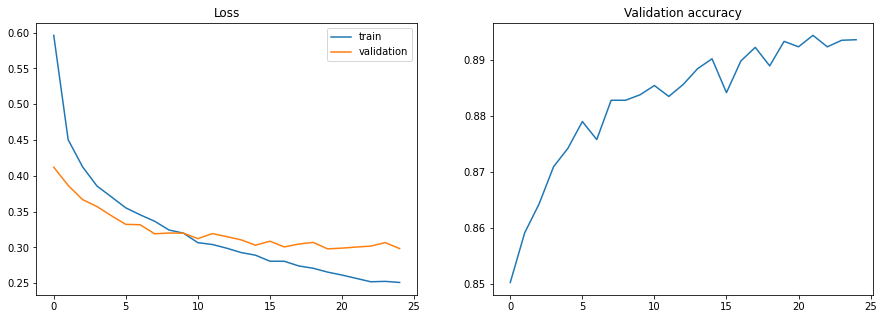

In [153]:
plot_train_process(train_loss, test_loss, test_accuracy)

### Task 2: Overfit it.
Build a network that will overfit to this dataset. Demonstrate the overfitting in the appropriate way (e.g. plot loss and accurasy on train and test set w.r.t. network complexity).

*Note:* you also might decrease the size of `train` dataset to enforce the overfitting and speed up the computations.

In [141]:
class OverfittingNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(), # This layer converts image into a vector to use Linear layers afterwards
            # Your network structure comes here
            nn.Linear(input_shape, 500),
            nn.ReLU(),
            nn.Linear(500, 250),
            nn.ReLU(),
            nn.Linear(250, num_classes)
        )
        
    def forward(self, inp):       
        out = self.model(inp)
        return out

In [142]:
torchsummary.summary(OverfittingNeuralNetwork().to(device), (28*28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 500]         392,500
              ReLU-3                  [-1, 500]               0
            Linear-4                  [-1, 250]         125,250
              ReLU-5                  [-1, 250]               0
            Linear-6                   [-1, 10]           2,510
Total params: 520,260
Trainable params: 520,260
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.02
Params size (MB): 1.98
Estimated Total Size (MB): 2.01
----------------------------------------------------------------


In [143]:
model = OverfittingNeuralNetwork().to(device)
opt = SGD(model.parameters(), lr=1e-1)
loss_func = nn.CrossEntropyLoss()


In [144]:
train_loss, test_loss, test_accuracy = train_test_loop(model,train_loader, test_loader, opt, loss_func, n_epochs=25)

100%|██████████| 25/25 [02:19<00:00,  5.59s/it]


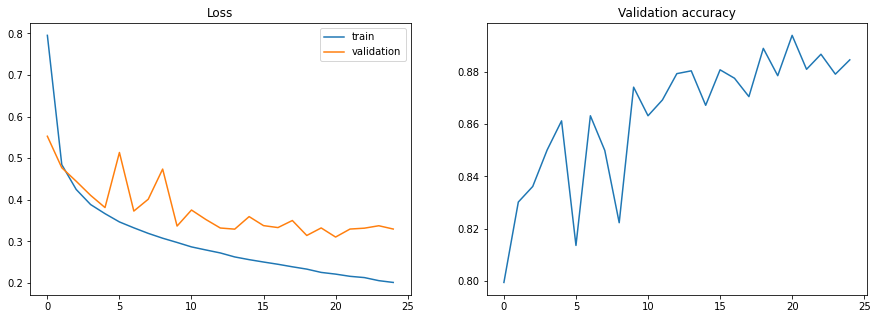

In [145]:
plot_train_process(train_loss, test_loss, test_accuracy)

### Task 3: Fix it.
Fix the overfitted network from the previous step (at least partially) by using regularization techniques (Dropout/Batchnorm/...) and demonstrate the results. 

In [161]:
class FixedNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(), # This layer converts image into a vector to use Linear layers afterwards
            # Your network structure comes here
            nn.Linear(input_shape, 500),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(500, 250),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(250, num_classes)
        )
        
    def forward(self, inp):       
        out = self.model(inp)
        return out

In [155]:
torchsummary.summary(FixedNeuralNetwork().to(device), (28*28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 500]         392,500
              ReLU-3                  [-1, 500]               0
           Dropout-4                  [-1, 500]               0
            Linear-5                  [-1, 250]         125,250
              ReLU-6                  [-1, 250]               0
           Dropout-7                  [-1, 250]               0
            Linear-8                   [-1, 10]           2,510
Total params: 520,260
Trainable params: 520,260
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.02
Params size (MB): 1.98
Estimated Total Size (MB): 2.01
----------------------------------------------------------------


In [162]:
model = FixedNeuralNetwork().to(device)
opt = SGD(model.parameters(), lr=1e-1)
loss_func = nn.CrossEntropyLoss()


In [163]:
train_loss, test_loss, test_accuracy = train_test_loop(model,train_loader, test_loader, opt, loss_func, n_epochs=25)

100%|██████████| 25/25 [02:20<00:00,  5.63s/it]


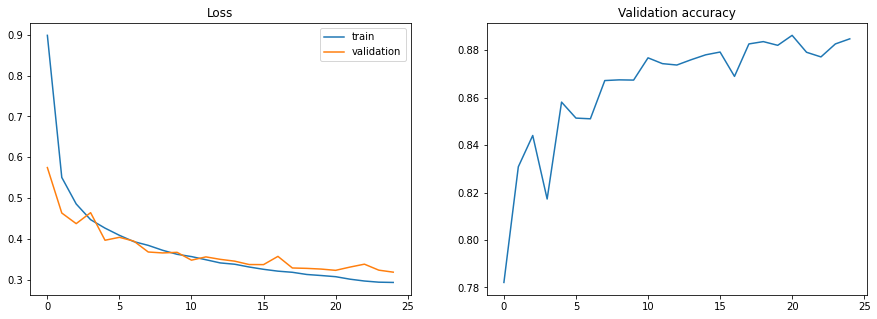

In [164]:
plot_train_process(train_loss, test_loss, test_accuracy)

### Conclusions:
_Write down small report with your conclusions and your ideas._

В первой части задания я построила сеть, в которой наблюдается небольшое переобучение. Затем я усилила этот эффект, немного поменяв размерности линейных слоев и убрав все dropout'ы и batchnorm'ы. Видно, что в этом случае сеть стало гораздо более нестабильна, наблюдаются большие скачки в accuracy. В третьей части я сохранила архитектуру предыдущей сети, но добавила слои dropout. Из графика видно, что переобучения нет, сеть работает стабильно.